In [1]:
# Figure method relaxation curve based on recon_1,, 
import os
import sys
import nibabel as nib
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

from cmcrameri import cm

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

# Get the current working directory (from where the notebook is running)
current_dir = os.getcwd()

# Add the project root directory to the Python path
project_root = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(project_root)


from utils.qmri_utils import *
from utils.ada_utils import *

import statsmodels.api as sm
from scipy.optimize import minimize, differential_evolution, curve_fit

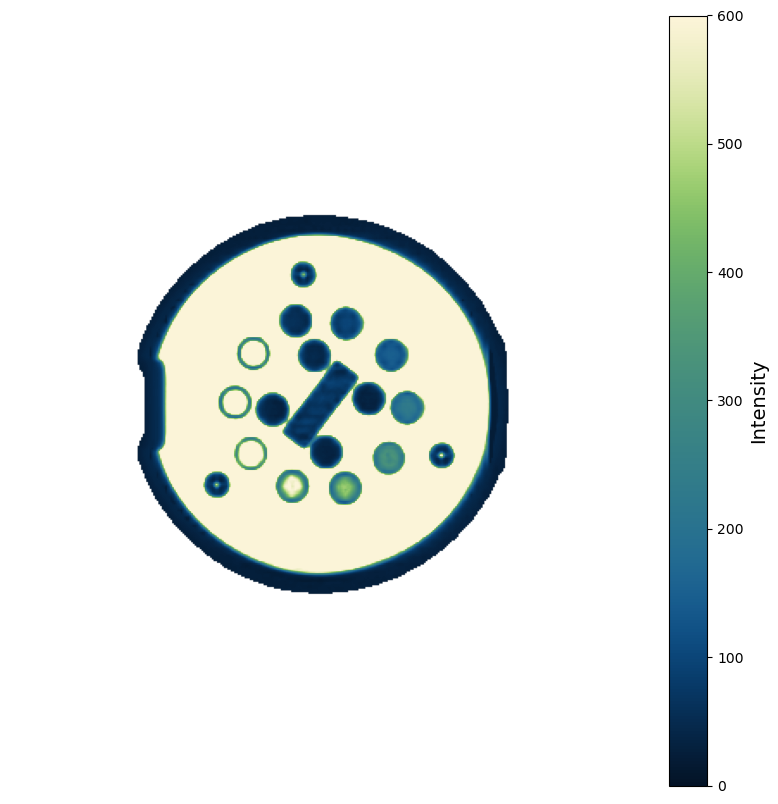

In [3]:
## Figure 2 - in vitro ablation gaussian - gaussian-rician - rician - head coil
# Data: prj-002_sub-001_ses-02 (ses-04 or ses-08 also available)

body_coil = True
fit = 'gaussian'
if body_coil:
    flnm = f"/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-003/derivatives/recon_1mm_t2map/sub-001/ses-01/anat/sub-001_ses-01_recon_1mm_sim-0_t2map_ada-{fit}.nii.gz"
    img_array = sitk.GetArrayFromImage(sitk.ReadImage(flnm))
    slice_data = img_array[106, :,:]
    plot_name = f't2map_bodycoil_{fit}.pdf'
else:
    flnm = f"/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/derivatives/recon_1mm_t2map/sub-001/ses-02/anat/sub-001_ses-02_recon_1mm_sim-0_t2map_ada-{fit}.nii.gz"   
    img_array = sitk.GetArrayFromImage(sitk.ReadImage(flnm))
    slice_data = img_array[:, :,169]
    plot_name = f't2map_headcoil_{fit}.pdf'
    

alpha = np.ones(slice_data.shape)
alpha[slice_data == 0] = 0

plt.figure(figsize=(10,10)) 
#im= plt.imshow(slice_data, cmap=plt.cm.colors.ListedColormap(log_navia), origin='lower',vmin=0,vmax=200,alpha=alpha) # initial 40 - 250
im= plt.imshow(slice_data, cmap=cm.navia, origin='lower',vmin=0,vmax=600,alpha=alpha) # initial 40 - 250
#plt.title(f'{sub} - slice {slice_index[sub]}')
plt.axis('off')  # Turn off the axis

cbar = plt.colorbar(im)
cbar.set_label('Intensity', fontsize=14) 
plt.savefig(f"/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/ada/fig2_ablation_fit/{plot_name}")
plt.show()




In [8]:

low_field = False
if low_field:

    path_recon = '/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/derivatives/recon_1mm/sub-001/ses-08/anat/'
    path_label = '/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/derivatives/recon_1mm_label/sub-001/ses-08/anat/sub-001_ses-08_te-114_recon_1mm_label.nii.gz'
    path_recon = '/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/derivatives/recon_1mm/sub-001/ses-08/anat/'
    pattern = 'sub-001_ses-08_te-'
else:
    path_recon = '/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/derivatives/recon_1mm/sub-001/ses-06/anat/'
    path_label = '/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/derivatives/recon_1mm_label/sub-001/ses-06/anat/sub-001_ses-06_te-113_recon_1mm_label.nii.gz'
    path_recon = '/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-002/derivatives/recon_1mm/sub-001/ses-06/anat/'
    pattern = 'sub-001_ses-06_te-'

label_array = sitk.GetArrayFromImage(sitk.ReadImage(path_label))

# List to store the images and their TE values
images = {}
te_values = []

# Iterate through the files in the directory
for filename in os.listdir(path_recon):
    if filename.endswith('.nii.gz') and pattern in filename:
        # Extract TE value from the filename
        te_value = int(filename.split('_te-')[1].split('_')[0])
        te_values.append(te_value)
        
        # Load the image
        image = sitk.ReadImage(os.path.join(path_recon, filename))
        image_array = sitk.GetArrayFromImage(image)
        
        # Store the image array in the dictionary with the TE value as the key
        images[te_value] = image_array





In [9]:
from scipy.optimize import curve_fit
# Sort TE values
te_values.sort()
# Filter for specific labels
labels_of_interest = [1,2,3,4,5]

# Initialize a dictionary to store the label and corresponding voxel values
label_dict = {}

# Iterate through each label of interest and collect the corresponding voxel values from each image
for label in labels_of_interest:
    # Find the voxel indices for the current label
    voxel_indices = np.where(label_array == label)
    
    # Collect the voxel values for each TE value
    voxel_values = {}
    for te in te_values:
        voxel_values[te] = images[te][voxel_indices]
    
    # Store the voxel values in the dictionary
    label_dict[label] = voxel_values

    # Calculate and print the mean and standard deviation for each label of interest and TE value
for label in labels_of_interest:
    print(f"Label: {label}")
    for te in te_values:
        voxels = label_dict[label][te]
        mean_val = np.mean(voxels)
        std_val = np.std(voxels)
        print(f"  TE: {te}, Mean: {mean_val:.2f}, Std: {std_val:.2f}")

Label: 1
  TE: 113, Mean: 746.80, Std: 32.84
  TE: 133, Mean: 723.05, Std: 33.45
  TE: 152, Mean: 695.22, Std: 32.42
  TE: 176, Mean: 657.33, Std: 26.44
  TE: 203, Mean: 617.16, Std: 19.35
  TE: 230, Mean: 579.07, Std: 15.35
  TE: 254, Mean: 547.92, Std: 12.85
  TE: 296, Mean: 495.31, Std: 11.24
Label: 2
  TE: 113, Mean: 483.38, Std: 43.15
  TE: 133, Mean: 457.91, Std: 43.44
  TE: 152, Mean: 426.59, Std: 40.28
  TE: 176, Mean: 386.72, Std: 32.92
  TE: 203, Mean: 344.84, Std: 21.32
  TE: 230, Mean: 307.57, Std: 13.99
  TE: 254, Mean: 278.80, Std: 11.91
  TE: 296, Mean: 232.86, Std: 11.88
Label: 3
  TE: 113, Mean: 339.95, Std: 29.44
  TE: 133, Mean: 303.78, Std: 29.81
  TE: 152, Mean: 263.37, Std: 25.52
  TE: 176, Mean: 219.10, Std: 20.16
  TE: 203, Mean: 176.80, Std: 18.44
  TE: 230, Mean: 142.75, Std: 22.80
  TE: 254, Mean: 121.25, Std: 24.22
  TE: 296, Mean: 88.79, Std: 26.59
Label: 4
  TE: 113, Mean: 230.10, Std: 21.37
  TE: 133, Mean: 184.93, Std: 22.16
  TE: 152, Mean: 143.66, Std:

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 682.6313450025505
        x: [ 6.300e+02  1.781e+02]
      nit: 5
      jac: [ 5.525e+00  0.000e+00]
     nfev: 21
     njev: 7
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 371.64549808526056
        x: [ 6.300e+02  9.051e+01]
      nit: 4
      jac: [ 1.501e+00 -1.705e-05]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 85.50940218215257
        x: [ 6.300e+02  5.115e+01]
      nit: 5
      jac: [ 1.504e-01  3.482e-04]
     nfev: 27
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


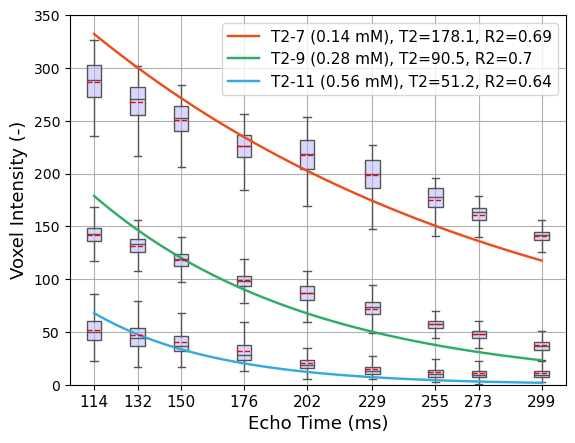

In [42]:
scattercolors = ['#36a9e1', '#2fac66', '#e94e1b', 'red', '#9370DB']

# Define the mono-exponential function for curve fitting
def gauss_model(te, M, T2):
    return M * np.exp(-te / T2)

def gauss_obj(params, TEeffs, signal):
        k, t2 = params
        model = gauss_model(TEeffs, k, t2)
        residuals = signal - model

        return np.sum(residuals**2) / len(signal)

# Create the plot
fig, axs = plt.subplots()
boxcol = '#555555'
colors = ['#e94e1b','#2fac66','#36a9e1']
rois = ['T2-7 (0.14 mM)', 'T2-9 (0.28 mM)','T2-11 (0.56 mM)']


for i, label in enumerate(labels_of_interest):
    vx_med = []
    TEs = []

    for te in te_values:
        data = label_dict[label][te]
        bplot = axs.boxplot(data, positions=[te], showfliers=False, widths=6, patch_artist=True,
                            boxprops=dict(edgecolor=boxcol), whiskerprops=dict(color=boxcol),
                            medianprops=dict(color=boxcol), capprops=dict(color=boxcol),
                            meanline=True, showmeans=True, meanprops=dict(color='red'))
        
        for patch in bplot['boxes']:
            patch.set_facecolor((0.7, 0.7, 1, 0.5))
        
        vx_med.append(np.mean(data))
        TEs.append(te)

    TEs = np.array(TEs)
    vx_med = np.array(vx_med)
    
    # Initial guesses for M, T2, and C
    initial_guess = [400, 200, 5]
    
    # Perform curve fitting
    #params, covariance = curve_fit(mono_exp, TEs, vx_med, p0=initial_guess, bounds=([0, 10, 5], [40000, 4000, 20]))

    fit_params =    {   "initial_guess": [630, 165],
                                "param_bounds": [(630,900),(30,600)],
                                "solver": "L-BFGS-B",
                                "options": {
                                    #"gtol": 1e-16,
                                    "ftol": 1e-6,
                                    "maxls": 50,
                                    #"maxiter": 1000,
                                    "disp": False
                                }
                            }

    result = minimize(gauss_obj, 
                          fit_params['initial_guess'], 
                          args=(TEs, vx_med),
                          method = fit_params['solver'], 
                          bounds=fit_params['param_bounds'],
                          options=fit_params['options'])
    print(result)
    # Compute R2
    fitted_values = gauss_model(TEs, *result.x)
    residuals = vx_med - fitted_values
    total_sum_squares = np.sum((vx_med - np.mean(vx_med))**2)
    sum_squares_residuals = np.sum(residuals**2)
    r_squared = np.round(1 - (sum_squares_residuals / total_sum_squares), 5)

    # Plot the fitted curve
    x = np.linspace(min(te_values), max(te_values), 100)
    y = gauss_model(x, *result.x)
    
    axs.set_ylabel('Voxel Intensity (-)', fontsize=13)
    axs.set_xlabel('Echo Time (ms)', fontsize=13)
    axs.set_xticks(te_values)
    axs.set_xticklabels([str(te) for te in te_values],fontsize=11)
    axs.grid(True, zorder=0)
    axs.set_xlim([min(te_values) - 10, max(te_values) + 10])
    axs.set_ylim([-50, max(vx_med) + 200])
    axs.plot(x, y, linestyle='-', color=colors[i], alpha=1, linewidth='1.75',
             label=f"{rois[i]}, T2={np.round(result.x[1], 1)}, R2={np.round(r_squared, 2)}")
    axs.legend(loc='upper right', fontsize=11)
    axs.set_ylim([0,350])

plt.savefig('/home/mroulet/Documents/Data/qMRI/CHUV/freemax/projects/prj-003/ada/figures/methods.pdf',transparent=True)
plt.show()


